<h1>Advanced lane detection steps:</h1>

* Obtain correction matrix for lense distortion

* Convert images to HLS format and extract S channel data

* Get bird eye view of lanes

* Apply sobel filters to get edge detection

* Apply thresholds in differential output - i.e. threshold against magnitude and direction

* Use histogram data to detect left and right lanes and draw 2nd order polynomial line

* Find centrepoint of polynomial line

* Augment data with line data

In [2]:
#STEP 1: Obtain correction matrix for lense detection, 
# Code taken from https://github.com/udacity/CarND-Advanced-Lane-Lines/examples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from IPython.display import Image
from IPython.display import display
import math
import glob
import pickle

%matplotlib inline

def corner_details():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    gray = ''
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open( "camera_calibration_result.p", "wb" ))        

def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

In [3]:
corner_details()
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

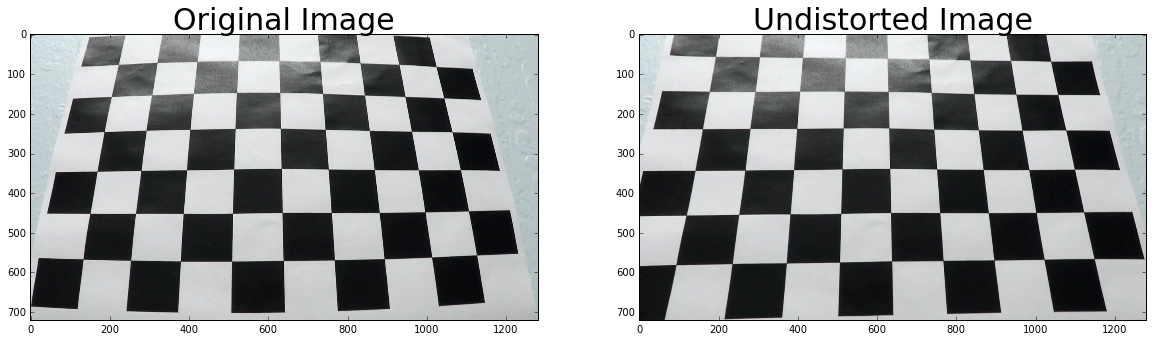

In [4]:
#Undistort test image
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [5]:
#Compute perspetive transform
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

In [139]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cal_undistort(img, mtx, dist)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = gray.shape

    src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    # Return the resulting image
    return warped

In [268]:
#Image filters
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
   # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
       
    abs_sobel = np.absolute(abs_sobel)
    binary_output = np.zeros_like(abs_sobel)
    # Inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <=thresh[1])] = 1
    # Rescale back to 8 bit integer

    scaled_sobel = np.uint8(255*binary_output/np.max(binary_output))
    #plt.imshow(scaled_sobel, cmap ='gray')
    return scaled_sobel

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/4)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    #plt.imshow(binary_output, cmap ='gray')
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 255)): 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #Rescale to 8 bit
    scale_factor = np.max(binary_output)/255
    gradmag = (binary_output/scale_factor).astype(np.uint8) 
    #plt.imshow(gradmag, cmap ='gray')
    return gradmag

def combined_filters(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(50, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(50, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20,150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.6,1.1))
    plt.imshow(grady,cmap='gray')
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

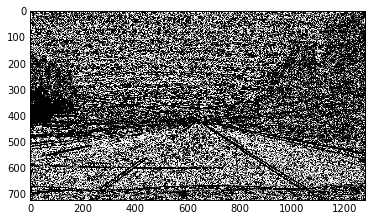

In [269]:
#Test Sobel filters and color filters
test_img = cv2.imread('test_images/straight_lines2.jpg')
img2 =  combined_filters(test_img)
#plt.imshow(img2, cmap ='gray')
#plt.imshow(test_img)

In [93]:
#Color threshold in HLS channel
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [3]:
def process_image(image):
    #pipeline
    #greyscale image
    gray = grayscale(img)
    
    #Undistort image
    
    
    #apply color filter for white and yellow lines
    img = color_filter(image)
    
    #histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #apply Gaussian blur
    gaus_gray = gaussian_blur(cl1, 7)

    #apply sobel edge detectors
    
    
    #apply image segmentation
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 300), (490, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    reg_gray = region_of_interest(can_gray, vertices = vertices)
    
    #Apply histogram polyfit finder
    
    #apply image augmentation
    lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=1, min_line_len=10, max_line_gap=1)

    #apply line extrapolation on hough_coord
    draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)
    return draw_lanes

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)